In [1]:
# --- Predicción de Precios de Autos Usados ---

# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

print("Librerías para el Proyecto 2 importadas correctamente.")

# 2. Cargar el dataset
# Asegúrate de haber subido el archivo 'car details v4.csv'
df_cars = pd.read_csv('car details v4.csv')
print("Dataset de autos cargado exitosamente.")

# 3. Exploración inicial
print("\nPrimeras 5 filas del dataset de autos:")
print(df_cars.head())

print("\nInformación general del dataset:")
df_cars.info()

print("\nEstadísticas descriptivas de las columnas numéricas:")
print(df_cars.describe())

Librerías para el Proyecto 2 importadas correctamente.
Dataset de autos cargado exitosamente.

Primeras 5 filas del dataset de autos:
            Make                            Model    Price  Year  Kilometer  \
0          Honda              Amaze 1.2 VX i-VTEC   505000  2017      87150   
1  Maruti Suzuki                  Swift DZire VDI   450000  2014      75000   
2        Hyundai             i10 Magna 1.2 Kappa2   220000  2011      67000   
3         Toyota                         Glanza G   799000  2019      37500   
4         Toyota  Innova 2.4 VX 7 STR [2016-2020]  1950000  2018      69000   

  Fuel Type Transmission   Location   Color   Owner Seller Type   Engine  \
0    Petrol       Manual       Pune    Grey   First   Corporate  1198 cc   
1    Diesel       Manual   Ludhiana   White  Second  Individual  1248 cc   
2    Petrol       Manual    Lucknow  Maroon   First  Individual  1197 cc   
3    Petrol       Manual  Mangalore     Red   First  Individual  1197 cc   
4    Diesel

In [7]:
# Hacemos una copia para no modificar el original
df_clean = df_cars.copy()

# 1. Eliminar filas con valores nulos para tener un dataset de partida completo
df_clean.dropna(inplace=True)

# 2. Limpiar y convertir columnas de texto a numéricas (MÉTODO MEJORADO)

# Limpiar 'Engine' (quitar " cc" y convertir a número)
df_clean['Engine'] = df_clean['Engine'].str.replace(' cc', '').astype(int)

# El año actual es 2025
current_year = 2025 

# Creamos la nueva columna 'Car_Age' restando el año de fabricación del año actual
df_clean['Car_Age'] = current_year - df_clean['Year']

print("Se ha creado la columna 'Car_Age':")
# Mostramos las columnas originales y la nueva para comparar
print(df_clean[['Year', 'Car_Age']].head())# Limpiar 'Max Power' usando una expresión regular para extraer el número inicial.
# Esto es más robusto y manejará casos como '87 bhp' y el problemático '165@5500'.
# r'^(\d+\.?\d*)' busca un número (con o sin decimales) al principio de la cadena.
df_clean['Max Power'] = df_clean['Max Power'].str.extract(r'^(\d+\.?\d*)')[0]

# Hacemos lo mismo para 'Max Torque' para asegurar que sea robusto
df_clean['Max Torque'] = df_clean['Max Torque'].str.extract(r'^(\d+\.?\d*)')[0]
# --- FIN DE LA CORRECCIÓN ---


# Ahora convertimos estas nuevas columnas limpias a tipo numérico.
# errors='coerce' convertirá cualquier valor problemático restante en Nulo (NaN).
df_clean['Max Power'] = pd.to_numeric(df_clean['Max Power'], errors='coerce')
df_clean['Max Torque'] = pd.to_numeric(df_clean['Max Torque'], errors='coerce')


# Volvemos a eliminar nulos en caso de que la conversión haya creado alguno
df_clean.dropna(inplace=True)


# Verificamos los cambios
print("Información del dataset DESPUÉS de la limpieza:")
df_clean.info()

print("\nVerificando los tipos de datos de las columnas limpiadas:")
print(df_clean[['Engine', 'Max Power', 'Max Torque']].dtypes)

Información del dataset DESPUÉS de la limpieza:
<class 'pandas.core.frame.DataFrame'>
Index: 1874 entries, 0 to 2057
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                1874 non-null   object 
 1   Model               1874 non-null   object 
 2   Price               1874 non-null   int64  
 3   Year                1874 non-null   int64  
 4   Kilometer           1874 non-null   int64  
 5   Fuel Type           1874 non-null   object 
 6   Transmission        1874 non-null   object 
 7   Location            1874 non-null   object 
 8   Color               1874 non-null   object 
 9   Owner               1874 non-null   object 
 10  Seller Type         1874 non-null   object 
 11  Engine              1874 non-null   int32  
 12  Max Power           1874 non-null   float64
 13  Max Torque          1874 non-null   float64
 14  Drivetrain          1874 non-null   object 
 15  Length      

In [9]:
# Obtenemos el año actual
current_year = 2025 # Usamos el año actual de nuestra sesión

# Creamos la nueva columna 'Car_Age'
df_clean['Car_Age'] = current_year - df_clean['Year']

print("\nPrimeras filas con la nueva columna 'Car_Age':")
print(df_clean[['Year', 'Car_Age']].head())


Primeras filas con la nueva columna 'Car_Age':
   Year  Car_Age
0  2017        8
1  2014       11
2  2011       14
3  2019        6
4  2018        7


In [11]:
# Seleccionamos las columnas categóricas que tienen pocas opciones únicas
categorical_cols = ['Fuel Type', 'Transmission', 'Owner', 'Seller Type']

# Usamos pd.get_dummies() para hacer el One-Hot Encoding.
# Esto crea nuevas columnas para cada categoría.
dummies = pd.get_dummies(df_clean[categorical_cols], drop_first=True, dtype=int)

# Unimos estas nuevas columnas numéricas a nuestro dataframe principal
df_model_ready = pd.concat([df_clean, dummies], axis=1)

print("\nDataset con las nuevas columnas 'dummy' añadidas.")
# Usamos .columns para ver todas las columnas nuevas
print("Nuevas columnas:", dummies.columns.tolist())


Dataset con las nuevas columnas 'dummy' añadidas.
Nuevas columnas: ['Fuel Type_CNG + CNG', 'Fuel Type_Diesel', 'Fuel Type_Hybrid', 'Fuel Type_LPG', 'Fuel Type_Petrol', 'Fuel Type_Petrol + CNG', 'Transmission_Manual', 'Owner_Second', 'Owner_Third', 'Owner_UnRegistered Car', 'Seller Type_Corporate', 'Seller Type_Individual']


In [13]:
# Lista de columnas originales que ya no necesitamos para el modelo
columns_to_drop = ['Make', 'Model', 'Year', 'Location', 'Color', 'Drivetrain', 
                   'Fuel Type', 'Transmission', 'Owner', 'Seller Type']

# Creamos el dataset final eliminando esas columnas
df_final = df_model_ready.drop(columns=columns_to_drop)

# Reordenamos las columnas para tener nuestro objetivo ('Price') al principio. Es solo por orden.
price_col = df_final.pop('Price')
df_final.insert(0, 'Price', price_col)


print("\n¡Dataset final 100% numérico y listo para el modelo!")
print(df_final.head())

print("\nRevisión final de los tipos de datos:")
df_final.info()


¡Dataset final 100% numérico y listo para el modelo!
     Price  Kilometer  Engine  Max Power  Max Torque  Length   Width  Height  \
0   505000      87150    1198       87.0    109.0000  3990.0  1680.0  1505.0   
1   450000      75000    1248       74.0    190.0000  3995.0  1695.0  1555.0   
2   220000      67000    1197       79.0    112.7619  3585.0  1595.0  1550.0   
3   799000      37500    1197       82.0    113.0000  3995.0  1745.0  1510.0   
4  1950000      69000    2393      148.0    343.0000  4735.0  1830.0  1795.0   

   Seating Capacity  Fuel Tank Capacity  ...  Fuel Type_Hybrid  Fuel Type_LPG  \
0               5.0                35.0  ...                 0              0   
1               5.0                42.0  ...                 0              0   
2               5.0                35.0  ...                 0              0   
3               5.0                37.0  ...                 0              0   
4               7.0                55.0  ...                

In [15]:
# --- ENTRENAMIENTO DEL MODELO

In [17]:
# 'X' serán todas las columnas EXCEPTO 'Price'
X = df_final.drop('Price', axis=1)

# 'y' será únicamente la columna 'Price'
y = df_final['Price']

print("Forma de X (features):", X.shape)
print("Forma de y (target):", y.shape)

Forma de X (features): (1874, 22)
Forma de y (target): (1874,)


In [19]:
# Usamos la función train_test_split que importamos al principio
# test_size=0.2 significa que el 20% de los datos será para prueba
# random_state=42 asegura que la división sea siempre la misma, para que los resultados sean reproducibles
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Datos para entrenamiento:", X_train.shape[0])
print("Datos para prueba:", X_test.shape[0])

Datos para entrenamiento: 1499
Datos para prueba: 375


In [21]:
# 1. Crear una instancia del modelo de Regresión Lineal
model = LinearRegression()

# 2. Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

print("¡Modelo entrenado exitosamente!")

¡Modelo entrenado exitosamente!


In [23]:
# El modelo usará lo que aprendió de X_train para predecir los precios de X_test
y_pred = model.predict(X_test)

print("Predicciones realizadas sobre el conjunto de prueba.")

Predicciones realizadas sobre el conjunto de prueba.


In [25]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- Resultados de la Evaluación ---")
print(f"Error Absoluto Medio (MAE): {mae:,.2f}")
print(f"Coeficiente de Determinación (R²): {r2:.2f}")

if r2 > 0.7:
    print("\n¡Un R² por encima de 0.7 es un resultado bastante bueno para un primer modelo!")
else:
    print("\nEs un buen punto de partida, pero podríamos mejorar el modelo con más datos o características.")


--- Resultados de la Evaluación ---
Error Absoluto Medio (MAE): 899,992.48
Coeficiente de Determinación (R²): 0.57

Es un buen punto de partida, pero podríamos mejorar el modelo con más datos o características.


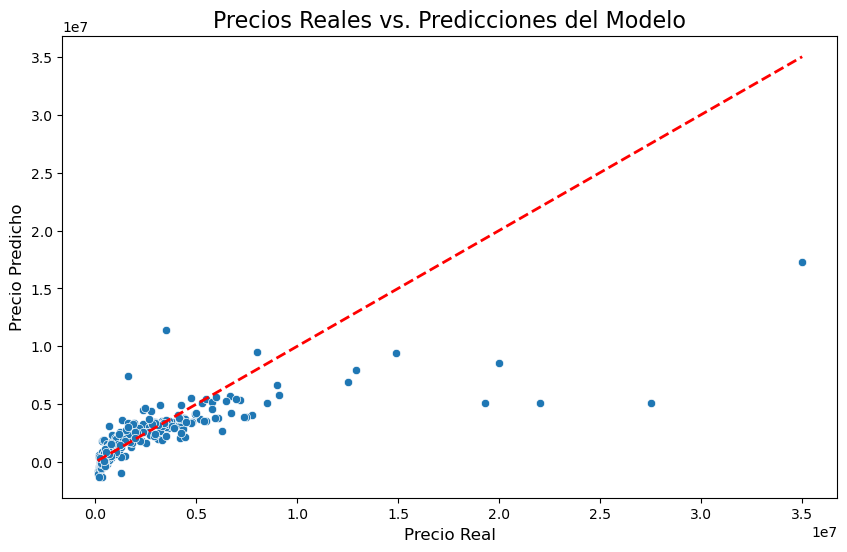

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Precios Reales vs. Predicciones del Modelo', fontsize=16)
plt.xlabel('Precio Real', fontsize=12)
plt.ylabel('Precio Predicho', fontsize=12)

# Dibujamos una línea roja de 45 grados. Si los puntos están cerca de esta línea, la predicción es buena.
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.show()

In [34]:
# NEW MODEL - Random Forest 

# 1. Importar el nuevo modelo
from sklearn.ensemble import RandomForestRegressor

# 2. Crear una instancia del modelo Random Forest
# n_estimators es el número de 'árboles' que construirá. 100 es un buen punto de partida.
# random_state es para la reproducibilidad.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 3. Entrenar el nuevo modelo (¡el proceso es idéntico!)
print("Entrenando el modelo Random Forest...")
rf_model.fit(X_train, y_train)
print("¡Modelo Random Forest entrenado!")

# 4. Hacer nuevas predicciones
y_pred_rf = rf_model.predict(X_test)

# 5. Evaluar el nuevo modelo y comparar
print("\n--- Resultados de la Evaluación (Random Forest) ---")
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Error Absoluto Medio (MAE): {mae_rf:,.2f}")
print(f"Coeficiente de Determinación (R²): {r2_rf:.2f}")

print("\n--- Comparación ---")
print(f"R² Regresión Lineal: {r2:.2f}")
print(f"R² Random Forest: {r2_rf:.2f}")

Entrenando el modelo Random Forest...
¡Modelo Random Forest entrenado!

--- Resultados de la Evaluación (Random Forest) ---
Error Absoluto Medio (MAE): 467,412.90
Coeficiente de Determinación (R²): 0.67

--- Comparación ---
R² Regresión Lineal: 0.57
R² Random Forest: 0.67


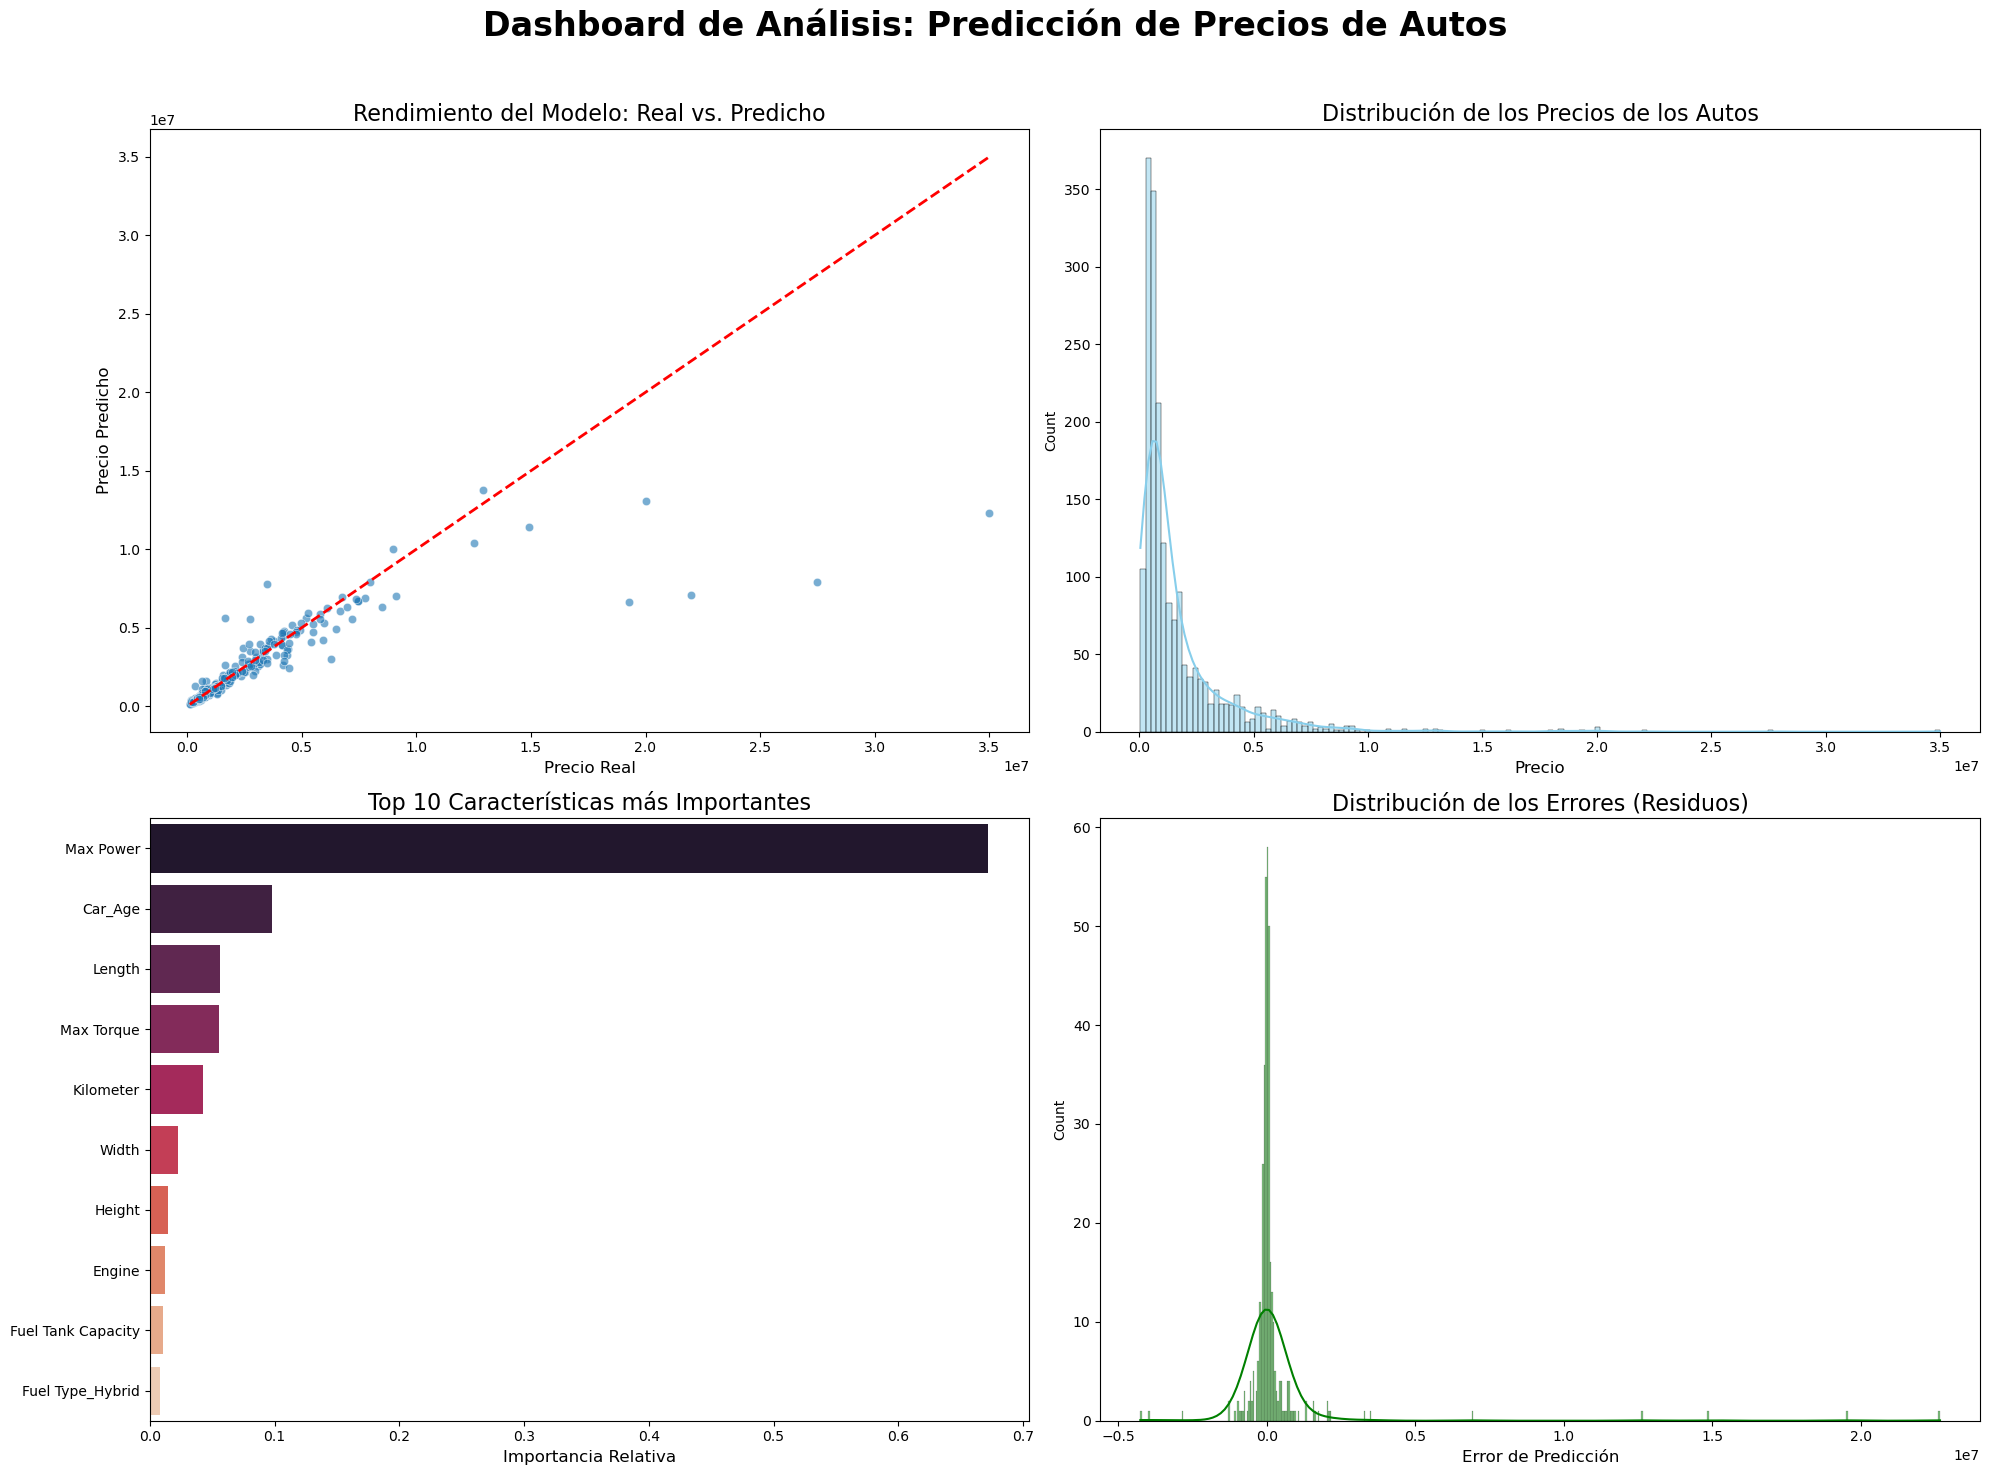

In [45]:
# --- DASHBOARD DEL PROYECTO ---

# 1. Regenerar el dataset final 
df_cars = pd.read_csv('car details v4.csv')
df_clean = df_cars.copy()
df_clean.dropna(inplace=True)
df_clean['Engine'] = df_clean['Engine'].str.replace(' cc', '').astype(int)
df_clean['Max Power'] = pd.to_numeric(df_clean['Max Power'].str.extract(r'^(\d+\.?\d*)')[0], errors='coerce')
df_clean['Max Torque'] = pd.to_numeric(df_clean['Max Torque'].str.extract(r'^(\d+\.?\d*)')[0], errors='coerce')
df_clean.dropna(inplace=True)
df_clean['Car_Age'] = 2025 - df_clean['Year']
dummies = pd.get_dummies(df_clean[['Fuel Type', 'Transmission', 'Owner', 'Seller Type']], drop_first=True, dtype=int)
df_model_ready = pd.concat([df_clean, dummies], axis=1)
columns_to_drop = ['Make', 'Model', 'Year', 'Location', 'Color', 'Drivetrain', 'Fuel Type', 'Transmission', 'Owner', 'Seller Type']
df_final = df_model_ready.drop(columns=columns_to_drop)
price_col = df_final.pop('Price')
df_final.insert(0, 'Price', price_col)

# 2. Regenerar el modelo y las predicciones
X = df_final.drop('Price', axis=1)
y = df_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 3. Crear el Dashboard
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.suptitle('Dashboard de Análisis: Predicción de Precios de Autos', fontsize=24, weight='bold')

# Gráfico 1: Rendimiento del Modelo (Real vs. Predicho)
sns.scatterplot(x=y_test, y=y_pred_rf, ax=axes[0, 0], alpha=0.6)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
axes[0, 0].set_title('Rendimiento del Modelo: Real vs. Predicho', fontsize=16)
axes[0, 0].set_xlabel('Precio Real', fontsize=12)
axes[0, 0].set_ylabel('Precio Predicho', fontsize=12)

# Gráfico 2: Distribución de los Precios
sns.histplot(df_final['Price'], ax=axes[0, 1], kde=True, color='skyblue')
axes[0, 1].set_title('Distribución de los Precios de los Autos', fontsize=16)
axes[0, 1].set_xlabel('Precio', fontsize=12)

# Gráfico 3: Importancia de las Característica
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
sns.barplot(x=importances.values, y=importances.index, ax=axes[1, 0], palette='rocket',
            hue=importances.index, legend=False)
axes[1, 0].set_title('Top 10 Características más Importantes', fontsize=16)
axes[1, 0].set_xlabel('Importancia Relativa', fontsize=12)
axes[1, 0].set_ylabel(None) # Limpiamos la etiqueta Y para que no se vea sobrecargado

# Gráfico 4: Residuos (Errores de predicción)
residuals = y_test - y_pred_rf
sns.histplot(residuals, ax=axes[1, 1], kde=True, color='green')
axes[1, 1].set_title('Distribución de los Errores (Residuos)', fontsize=16)
axes[1, 1].set_xlabel('Error de Predicción', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [47]:
import joblib

# Guardamos el modelo entrenado en un archivo
joblib.dump(rf_model, 'modelo_autos_rf.pkl') 

# También necesitamos las columnas del modelo en el orden correcto
joblib.dump(X.columns, 'columnas_modelo.pkl')

print("Modelo y columnas guardados.")

Modelo y columnas guardados.
